In [136]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split as s_train_test_split
from surprise.model_selection import KFold
from surprise import Reader

from pyspark.mllib.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.tuning import (CrossValidator, ParamGridBuilder)

import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

import matplotlib.pyplot as plt
import datetime

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.metrics import make_scorer
from math import sqrt

from collections import OrderedDict 

# IEOR 4571 - Personalization - Project 1

#### Team members: 
Name, UNI/email, Github ID
* Megala Kannan, msk2245@columbia.edu, thisismeg
* Hojin Lee, hl3328@columbia.edu, hjlee9295
* Jung Ah Shin, js5569@columbia.edu, juliajungahshin
* Tiffany Zhu, tz2196@columbia.edu, tlzhu19


# TOC:
* [1. Introduction](#1)
* [2. Data Exploration](#2)
* [3. Modeling](#3)
    * [3.1 Baseline Model](#3-1)
        * [3.1.1 Accuracy of Baseline Model](#3-1-1)
        * [3.1.2 Coverage of Baseline Model](#3-1-2)
    * [3.2 Neighborhood-Based Collaborative Filtering](#3-2)
        * [3.2.1 Tunning Hyperparameters](#3-2-1)
        * [3.2.2 Accuracy of KNN Means Model](#3-2-2)
        * [3.2.3 Coverage of KNN Means Model](#3-2-3)
    * [3.3 Model-Based Collaborative Filtering](#3-3)
        * [3.3.1 Tunning Hyperparameters](#3-3-1)
        * [3.3.2 Accuracy of ALS Model](#3-3-2)
        * [3.3.3 Coverage of ALS Model](#3-3-3)
* [4. Evaluation](#4)
    * [4.1 Accuracy](#4-1)
        * [4.1.1 RMSE](#4-1-1)
        * [4.1.2 NDCG](#4-1-2)
    * [4.2 Coverage](#4-2)
    * [4.3 Changing Sample Size](#4-3)
* [5. Conclusion](#5)


# 1. Introduction <a class="anchor" id="1"></a>

# 2. Data Exploration <a class="anchor" id="2"></a>

1) Original data contains 138493 users and 26744 items (Approximately 20M ratings).

   Original data only contains users that rated more than 20 items. 
2) In order to develop our Item-based CF model with a small data set (Approx. <10,000 users / <1,000 items), we sampled the data based on the following rationale and steps:
    i) Remove ubiquitous items (e.g. top 0.5% most rated items across users) as well as items that have extremely few ratings (e.g. items rated only once). Recommending items that have been rated by majority of users are likely to be redundant and have less value in terms of novelty of the recommendation. Since we aim to provide item recommendations that the user might not have experienced yet, it seemed reasonable to remove top 0.5% of items that have been rated by many users. Regarding items that have extremely few ratings, these items would not contribute much in terms of item similarity, so we have decided to remove those user-item pairs with single ratings as well. 

Our goal is to provide movie recommendations based on items that...
- ubiquitous: likely that most/many users would have already watched l                                              
- few rating? : lack accuracy
-middle ground 

3) Then, we sampled a small dataset


(Recommendations cannot be made for cold start users/items)
Common sampling approaches:
- build the algorithm using only users/items with a minimum n interactions
- leave out m items from each user row, or leave out n users from each user row

In [3]:
ratings_df = pd.read_csv('ratings.csv')

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
userNum = len(ratings_df.userId.unique()) #138493 users
itemNum = len(ratings_df.movieId.unique()) #26744 items

print(userNum, itemNum)

138493 26744


In [6]:
df_item_summary = pd.DataFrame(ratings_df.groupby('movieId').size(), columns=['count'])
df_item_summary.describe()

,count
count,26744.000000
mean,747.841123
std,3085.818268
min,1.000000
25%,3.000000
50%,18.000000
75%,205.000000
max,67310.000000


We first need to check what percentage the top 0.5% most rated items constitute in terms of the entire rating data. Given our 20M rating dataset, the top 0.5% most rated items (ubiquitous) take up approximately 21.7% of the entire data. Therefore, the list top_05 would contain the item indices of top 0.5% most rated items, and one_item_idx would contain the list of items with only one rating. We will be removing user-item pairs based on these two lists.

In [7]:
df_item_summary = df_item_summary.sort_values(by='count', ascending=False) 
top_rated_movies = df_item_summary.nlargest(int(len(df_item_summary)*0.005), 'count') 
top_rated_movies.sum()/df_item_summary.sum()

count    0.217018
dtype: float64

In [8]:
print(top_rated_movies.sum())

count    4340412
dtype: int64


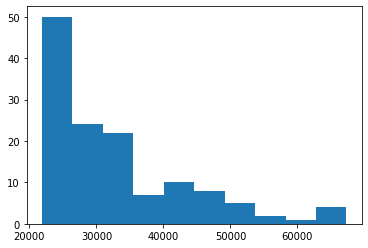

In [9]:
plt.hist(top_rated_movies['count'])
plt.show()

So now we remove the top 0.5% movies and the movies that were only rated once.

In [10]:
top_05 = list(top_rated_movies.index.values) #133 items 
one_item_idx = df_item_summary[df_item_summary['count']==1].index.tolist() #3972
remove_list = top_05 + one_item_idx #4105 items
print(len(remove_list)) 
new_ratings_df = ratings_df[~ratings_df.movieId.isin(top_05)]
new_ratings_df.head()

4105


,userId,movieId,rating,timestamp
1,1,29,3.5,1112484676
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
13,1,337,3.5,1094785709
18,1,653,3.0,1094785691


In [11]:
new_user = len(new_ratings_df.userId.unique())
new_item = len(new_ratings_df.movieId.unique())
print("Number of users: {}\nNumber of movies: {} \nTotal number rows: {}".format(new_user, new_item, len(new_ratings_df)))
new_ratings_df.describe()

Number of users: 137542
Number of movies: 26611 
Total number rows: 15659851


,userId,movieId,rating,timestamp
count,1.565985e+07,1.565985e+07,1.565985e+07,1.565985e+07
mean,6.901693e+04,1.117394e+04,3.445954e+00,1.110063e+09
std,4.004482e+04,2.187546e+04,1.057272e+00,1.585046e+08
min,1.000000e+00,3.000000e+00,5.000000e-01,7.896520e+08
25%,3.436200e+04,1.256000e+03,3.000000e+00,9.749575e+08
50%,6.908200e+04,2.712000e+03,3.500000e+00,1.108593e+09
75%,1.036000e+05,5.773000e+03,4.000000e+00,1.231299e+09
max,1.384930e+05,1.312620e+05,5.000000e+00,1.427784e+09


Since `new_ratings_df` still contains more than 1.5 million rows of data, we will now take different sized samples. More specificially, we will look at 0.001%, 0.05%, and 0.01% of `new_ratings_df` (randomly sampled).

In [16]:
percentages = [0.001, 0.005, 0.01]
all_sample_dfs = []
for sample_percentage in percentages:
    ratings_sample_df = new_ratings_df.sample(frac=sample_percentage, random_state=1)
    all_sample_dfs.append(ratings_sample_df)
    
    new_user = len(ratings_sample_df.userId.unique())
    new_item = len(ratings_sample_df.movieId.unique())
    print("Sample %: {}\nNumber of users: {}\nNumber of movies: {} \nTotal number rows: {}\n\n".format(
        sample_percentage, new_user, new_item, len(ratings_sample_df)))

Sample %: 0.001
Number of users: 12878
Number of movies: 4515 
Total number rows: 15660


Sample %: 0.005
Number of users: 41704
Number of movies: 8312 
Total number rows: 78299


Sample %: 0.01
Number of users: 61517
Number of movies: 10260 
Total number rows: 156599




# 3. Modeling <a class="anchor" id="3"></a>

## 3.1 Baseline Model <a class="anchor" id="3-1"></a>

In [17]:
# Baseline model: Use the average rating of a movie in the training set as a predicted rating in the test set.
# If movie trying to predict in test set doesn't exist in training, give it 0 rating?

def baseline_predictor(avg_ratings, X):
    predictions = []
    rated_movies = avg_ratings['movieId'].values
    
    for index, row in X.iterrows():
        movieId = row['movieId']
        if movieId in rated_movies:
            predicted_rating = avg_ratings[avg_ratings['movieId'] == movieId]['rating']
            predictions.append(float(predicted_rating))
        else:
            # TODO: should actually just remove this data point?
            predictions.append(0)
    
    final_df = X.copy()
    final_df['rating'] = predictions
    return final_df

In [18]:
def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

def get_ratings_for_each_user(df, rating_col_name='rating'):
    '''
    returns list of ratings for each user
    '''
    user_to_rating_dict = OrderedDict()
    relevent_per_user = []
    
    # predicted ratings per user
    for index, row in df.iterrows():
        userId = row['userId']
        rating = row[rating_col_name]
        if userId not in user_to_rating_dict:
            user_to_rating_dict[userId] = [rating]
        else:
            user_to_rating_dict[userId].append(rating)
            
    # create the relevent list
    for values in user_to_rating_dict.values():
        values = list(values)
        relevent_per_user.append(len(list(filter(lambda x: x>=3, values))))
    
    return list(user_to_rating_dict.values()), relevent_per_user

In [133]:
# Use baseline model to predict

baseline_rmses = []
baseline_rmses_train = []
baseline_ndcgs = []
baseline_ndcgs_train = []
baseline_predicted_dfs = []
baseline_predicted_train_dfs = []
baseline_training_dfs = []
baseline_test_dfs = []
for i in range(len(percentages)):
    start = datetime.datetime.now()
    print('Sample % {}\n Start time: {}'.format(percentages[i], str(start)))
    ratings_sample_df = all_sample_dfs[i]

    X = ratings_sample_df.loc[:, ratings_sample_df.columns != 'rating']
    y = ratings_sample_df.loc[:, ratings_sample_df.columns == 'rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    training_sample = X_train.copy()
    training_sample['rating'] = y_train
    avg_ratings = training_sample.groupby('movieId', as_index = False).mean()
    baseline_training_dfs.append(training_sample)
    
    test_sample = X_test.copy()
    test_sample['rating'] = y_test
    baseline_test_dfs.append(test_sample)
    
    print('\tStart predicting at {}...'.format(str(datetime.datetime.now())))
    # test predictions
    baseline_predicted_df = baseline_predictor(avg_ratings, X_test)
    baseline_predicted_dfs.append(baseline_predicted_df)
    # train predictions
    baseline_predicted_train_df = baseline_predictor(avg_ratings, X_train)
    baseline_predicted_train_dfs.append(baseline_predicted_train_df)
    print('\t...End predicting at {}.'.format(str(datetime.datetime.now())))
    
    print('\tStart RMSE at {}...'.format(str(datetime.datetime.now())))
    # RMSE on test set
    y_actual = y_test['rating']
    y_predicted = baseline_predicted_df['rating']
    baseline_rmse = sqrt(mean_squared_error(y_actual.tolist(), y_predicted.tolist()))
    baseline_rmses.append(baseline_rmse)
    
    # RMSE on train set
    y_actual_train = y_train['rating']
    y_predicted_train = baseline_predicted_train_df['rating']
    baseline_rmse_train = sqrt(mean_squared_error(y_actual_train.tolist(), y_predicted_train.tolist()))
    baseline_rmses_train.append(baseline_rmse_train)
    print('\t...End RMSE at {}.'.format(str(datetime.datetime.now())))
    
    
    print('\tStart NDCG at {}...'.format(str(datetime.datetime.now())))
    # NDCG on test set
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(baseline_predicted_df)
    baseline_ndcg = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    baseline_ndcgs.append(baseline_ndcg)
    
    # NDCG on train set
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(baseline_predicted_train_df)
    baseline_ndcg_train = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    baseline_ndcgs_train.append(baseline_ndcg_train)
    print('\t...End NDCG at {}.'.format(str(datetime.datetime.now())))
    
    end = datetime.datetime.now()
    print('\tTotal Time: {}'.format(str(end-start)))

Sample % 0.001
 Start time: 2019-11-05 00:18:32.269224
	Start predicting at 2019-11-05 00:18:32.415593...
	...End predicting at 2019-11-05 00:18:49.218512.
	Start RMSE at 2019-11-05 00:18:49.218598...
	...End RMSE at 2019-11-05 00:18:49.239604.
	Start NDCG at 2019-11-05 00:18:49.239721...
	...End NDCG at 2019-11-05 00:18:53.908419.
	Total Time: 0:00:21.639501
Sample % 0.005
 Start time: 2019-11-05 00:18:53.908756
	Start predicting at 2019-11-05 00:18:53.953405...
	...End predicting at 2019-11-05 00:20:11.858349.
	Start RMSE at 2019-11-05 00:20:11.858883...
	...End RMSE at 2019-11-05 00:20:11.887136.
	Start NDCG at 2019-11-05 00:20:11.887266...
	...End NDCG at 2019-11-05 00:20:48.193302.
	Total Time: 0:01:54.284705
Sample % 0.01
 Start time: 2019-11-05 00:20:48.193496
	Start predicting at 2019-11-05 00:20:48.277898...
	...End predicting at 2019-11-05 00:23:18.446491.
	Start RMSE at 2019-11-05 00:23:18.446753...
	...End RMSE at 2019-11-05 00:23:18.483975.
	Start NDCG at 2019-11-05 00:23:

### 3.1.1 Accuracy of Baseline Model <a class="anchor" id="3-1-1"></a>

### RMSE of Baseline Model

In [20]:
baseline_rmses, baseline_rmses_train

([1.6802065306456464, 1.1891280563833586, 1.0777108359990675],
 [0.7618152461605174, 0.8801984562025763, 0.9072231544147223])

### NDCG of Baseline Model

In [21]:
baseline_ndcgs, baseline_ndcgs_train

([0.2964599338478883, 0.21006881115672518, 0.19499626274599363],
 [0.19610899255506742, 0.18170832411769505, 0.18041086510043305])

### 3.1.2 Coverage of Baseline Model <a class="anchor" id="3-1-2"></a>

In [126]:
data_schema = StructType([
    StructField('userId',IntegerType(), False),
    StructField('movieId',IntegerType(), False),
    StructField('rating',FloatType(), False)])

spark_baseline_predicted_dfs = []
spark_baseline_predicted_train_dfs = []
for i in range(len(baseline_predicted_dfs)):
    test_df = baseline_predicted_dfs[i]
    new_sample_df = test_df.iloc[:, test_df.columns != 'timestamp']
    spark_baseline_predicted_dfs.append(spark.createDataFrame(new_sample_df, schema=data_schema))
    
    train_df = baseline_predicted_train_dfs[i]
    new_sample_df2 = train_df.iloc[:, train_df.columns != 'timestamp']
    spark_baseline_predicted_train_dfs.append(spark.createDataFrame(new_sample_df2, schema=data_schema))

In [127]:
baseline_test_item_coverages = get_item_coverage(spark_baseline_predicted_dfs)

Item Coverage (0.001% sample): 3.1%
Item Coverage (0.005% sample): 2e+01%
Item Coverage (0.01% sample): 2.5e+01%


In [128]:
baseline_test_user_coverages = get_user_coverage(spark_baseline_predicted_dfs)

User Coverage: (0.001% sample): 0.0%
User Coverage: (0.005% sample): 1.9%
User Coverage: (0.01% sample): 5.8%


In [129]:
baseline_train_item_coverages = get_item_coverage(spark_baseline_predicted_train_dfs)

Item Coverage (0.001% sample): 3.6e+01%
Item Coverage (0.005% sample): 5.1e+01%
Item Coverage (0.01% sample): 5.3e+01%


In [130]:
baseline_train_user_coverages = get_user_coverage(spark_baseline_predicted_train_dfs)

User Coverage: (0.001% sample): 5.4%
User Coverage: (0.005% sample): 3.4e+01%
User Coverage: (0.01% sample): 5.1e+01%


## 3.2 Neighborhood-Based Collaborative Filtering <a class="anchor" id="3-2"></a>

### 3.2.1 Tunning Hyperparameters <a class="anchor" id="3-2-1"></a>

In [143]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

In [147]:
def mean(l):
    return sum(l) / len(l)

kf = KFold(n_splits=3)
possibleK = [5,10,25]

knn_rmse_test = []
knn_rmse_train = []

for i in range(len(percentages)):
    sampled_df = baseline_training_dfs[i]
    data = Dataset.load_from_df(sampled_df[['userId', 'movieId', 'rating']], reader)
    
    knn_rmse_all_test = []
    knn_rmse_all_train = []
    for k in possibleK:
        start = datetime.datetime.now()
        print('parameter', k)
    
        rmses_test = []
        rmses_train = []
        algo = KNNWithMeans(k=k, sim_options={'name': 'cosine', 'user_based': False})
        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            rmse_train = accuracy.rmse(predictions)
            rmses_train.append(rmse_train)
            
        knn_rmse_all_train.append(mean(rmses_train))
    
        test_df = baseline_test_dfs[i]
        test_df = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)
        predictions_test = algo.test(test_df.build_full_trainset().build_testset())
        rmse_test = accuracy.rmse(predictions_test)
        knn_rmse_all_test.append(rmse_test)
            
        end = datetime.datetime.now()
    
    print('percentage: {}, k: {} , total time: {}'.format(percentage, k, str(end-start)))

    knn_rmse_test.append(knn_rmse_all_test)
    knn_rmse_train.append(knn_rmse_all_train)
    
    print('\n')


parameter 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0633
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0419
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0538
RMSE: 1.0507
parameter 10
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0585
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0496
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0500
RMSE: 1.0535
parameter 25
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0420
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0442
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0695
RMSE: 1.0485
percentage: 0.001, k: 25 , total time: 0:00:01.888176


parameter 5
Computing the cosine similarity matrix...
Done computi

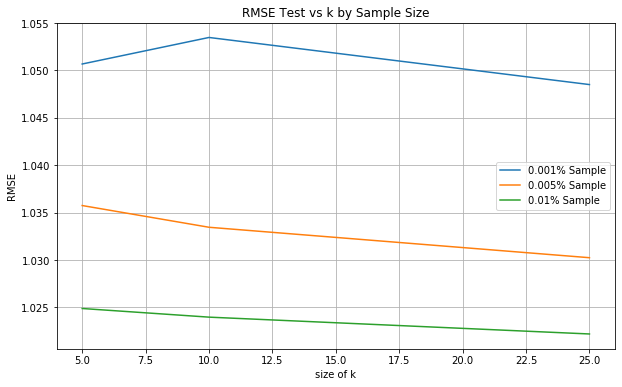

In [148]:
plt.figure(figsize=(10, 6))

for knn_rmse in knn_rmse_test:
    plt.plot(possibleK, knn_rmse)

plt.xlabel('size of k')
plt.ylabel('RMSE')
plt.title('RMSE Test vs k by Sample Size')
plt.legend(['{}% Sample'.format(p) for p in percentages])
plt.grid(True)
plt.show()

### 3.2.2 Accuracy of KNN Means Model <a class="anchor" id="3-2-2"></a>

### RMSE

The training RMSEs are similar to the test RMSEs.

In [149]:
# Test RMSE
knn_rmse_test

[[1.0506817596928166, 1.0534827857622457, 1.0485114418079646],
 [1.0357442964942292, 1.0334506993771981, 1.030237787733422],
 [1.0248771958923668, 1.023964874014258, 1.0221884957312877]]

In [150]:
# Train RMSE
knn_rmse_train

[[1.052981709558509, 1.0527074092618722, 1.0518893325021512],
 [1.036380478568988, 1.0399317321113437, 1.037380766725285],
 [1.028035506205932, 1.0273116606770987, 1.02445603362914]]

### !!! NDCG !!!

### 3.2.3 Coverage of KNN Means Model <a class="anchor" id="3-2-3"></a>

In [238]:
def create_knn_df(predictions_test):
    knn_predictions_list = []
    for i in range(len(predictions_test)):
        # userId, movieId, rating, predicted
        knn_predictions_list.append(list(predictions_test[i][:-1]))
        
    return pd.DataFrame(knn_predictions_list, columns = ['userId', 'movieId', 'rating', 'predicted'])

In [239]:
knn_predictions_dfs = []
spark_knn_predicted_dfs = []

best_ks = [25, 25, 25]
for i in range(len(baseline_training_dfs)):
    train_df = baseline_training_dfs[i]
    train_df = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
    algo = KNNWithMeans(k=best_ks[i], sim_options={'name': 'cosine', 'user_based': False})
    algo.fit(train_df.build_full_trainset())
    test_df = baseline_test_dfs[i]
    test_df = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)
    predictions_test = algo.test(test_df.build_full_trainset().build_testset())
    
    knn_predictions_df = create_knn_df(predictions_test)
    knn_predictions_dfs.append(knn_predictions_df)
    test_df = knn_predictions_df
    new_sample_df = test_df.iloc[:, test_df.columns != 'predicted']
    spark_knn_predicted_df = spark.createDataFrame(new_sample_df, schema=data_schema)
    spark_knn_predicted_dfs.append(spark_knn_predicted_df)
    
knn_item_coverages_test = get_item_coverage(spark_knn_predicted_dfs)
knn_user_coverages_test = get_user_coverage(spark_knn_predicted_dfs)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Item Coverage (0.001% sample): 2.2%
Item Coverage (0.005% sample): 1.9e+01%
Item Coverage (0.01% sample): 2.5e+01%
User Coverage: (0.001% sample): 0.14%
User Coverage: (0.005% sample): 2.2%
User Coverage: (0.01% sample): 5.5%


In [240]:
knn_item_coverages_test, knn_user_coverages_test

([2.2411953041622197, 18.60885275519422, 24.809413324494532],
 [0.1353637901861252, 2.216478696741855, 5.545544643661591])

In [269]:
knn_catalog_coverages = []
for knn_predictions_df in knn_predictions_dfs:
    knn_predictions_df.sort_values(by=['userId', 'predicted'])
    ratings_dictionary = dict(knn_predictions_df.set_index('userId').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
    N = len(knn_predictions_df['movieId'].unique())    
    knn_catalog_coverages.append(calculate_catalog_coverage(ratings_dictionary, N))


Catalog Coverage: 99.94739610731193%
Catalog Coverage: 98.30885625278148%
Catalog Coverage: 94.4639571834755%


In [268]:
def calculate_catalog_coverage(ratingsDict, N, k=3):
    '''
    k: top k movies
    N: total number of movies
    '''
    
#     totalMovies = []
#     for i in (testset):
#         totalMovies.append(i[1])
#     totalMovies = list(dict.fromkeys(totalMovies))

    recList = []
    for keys in ratingsDict.keys():
        
        if k >= len(ratingsDict[keys]):
            for row in ratingsDict[keys]:
                recList.append(row['movieId'])
        else:
            for index, item in enumerate(sorted(ratingsDict[keys], key=lambda x: -x['predicted'])):
                if index+1 <= k:
                    recList.append(item['movieId'])
                else:
                    pass
#     recList = list(dict.fromkeys(recList))
    #     return len(recList)/len(totalMovies)
    
    recommended_set = set(recList)

    coverage = (len(recommended_set) / N) * 100
    print('Catalog Coverage: {}%'.format(coverage))
    return coverage

## 3.3 Model-Based Collaborative Filtering: Matrix Factorization Using PySpark's Alternating Least Squares (ALS) <a class="anchor" id="3-3"></a>

We use the Alternating Least Square (ALS) model in PySpark with the same samples we used for the baseline model and the neighborhood-based model.

In [44]:
#Spark Session
spark =SparkSession.builder.appName('ALS').getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Load ratings data into PySpark dataframe
data_schema = StructType([
    StructField('userId',IntegerType(), False),
    StructField('movieId',IntegerType(), False),
    StructField('rating',FloatType(), False)])

movie_ratings = spark.read.csv('ratings.csv', 
                               header=True, schema=data_schema).cache()

We convert our samples (Pandas dataframes) into Spark dataframes.

In [45]:
# Create Spark DF from Pandas DF
all_sample_spark_dfs = []
for sample_df in all_sample_dfs:
    new_sample_df = sample_df.iloc[:, sample_df.columns != 'timestamp']
    spark_sample_df = spark.createDataFrame(new_sample_df, schema=data_schema)
    all_sample_spark_dfs.append(spark_sample_df)

In [46]:
# ALS model without tunning parameters
als = ALS(maxIter=5, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)

In [ ]:
# def sample_x_percent(sample_percentage):
#     subset_ratings = movie_ratings.sample(False, sample_percentage, 42)
#     (training, test) = subset_ratings.randomSplit([0.8, 0.2])
#     return training, test

# training, test = sample_x_percent(sample_percentage)
# user_tr_sample_count = training.select('userID').distinct().count()
# movie_tr_sample_count = training.select('movieID').distinct().count()
# user_tr_sample_count, movie_tr_sample_count

### Different Sample Sizes

In [47]:
all_training_sets = []
all_test_sets = []

for df in all_sample_spark_dfs:
    (training, test) = df.randomSplit([0.8, 0.2])
    all_training_sets.append(training)
    all_test_sets.append(test)
    
# for percentage in percentages:
#     trn, tst = sample_x_percent(percentage)
#     all_training_sets.append(trn)
#     all_test_sets.append(tst)

training_1, training_2, training_3 = all_training_sets
test_1, test_2, test_3 = all_test_sets

In [49]:
for training in all_training_sets:
    training.cache()
    user_tr_sample_count = training.select('userID').distinct().count()
    movie_tr_sample_count = training.select('movieID').distinct().count()
    print('users: ', user_tr_sample_count, ' movies: ', movie_tr_sample_count, ' total rows: ', training.count())

users:  10668  movies:  4070  total rows:  12577
users:  36300  movies:  7764  total rows:  62748
users:  54775  movies:  9601  total rows:  125300


### 3.3.1 Tunning Hyperparameters <a class="anchor" id="3-3-1"></a>

There are 3 hyperparameters to tune. First, we will tune `rank`, then `regParam`, and then `maxIter`. We use RSME to tune our parameters and cross validation with 3 folds. We do this on our traning set.

In [57]:
def tune_parameter(cv_func, paramGrid, percentages, all_training_sets):
    
    training_times = []
    cvModels = []
    results = []

    for i in range(len(percentages)):
        start_1 = datetime.datetime.now()
        cvModel = cv_func.fit(all_training_sets[i])
        end_1 = datetime.datetime.now()

        cvModels.append(cvModel)
        training_times.append(str(end_1 - start_1))
        results.append(list(zip(cvModel.avgMetrics, paramGrid)))

        print(str(end_1 - start_1))
    
    return training_times, cvModels, results
    

In [51]:
def plot_rmse_vs_param(cvModels, param_list, xlabel):
    plt.figure(figsize=(10, 6))
    for cvModel in cvModels: 
        plt.plot(param_list, cvModel.avgMetrics)

    plt.xlabel(xlabel)
    plt.ylabel('RMSE')
    plt.title('RMSE vs {} by Sample Size'.format(xlabel))
    plt.legend(['{}% Sample'.format(p) for p in percentages])
    plt.grid(True)
    plt.show()

####  Tunning Rank

In [52]:
# tunning rank
rank_list = [5, 10, 20]
paramGrid = (ParamGridBuilder().addGrid(als.rank, rank_list).build())

crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)

training_times, cvModels, results = tune_parameter(crossval, paramGrid, percentages, all_training_sets)

0:01:18.157035
0:01:46.070298
0:01:58.370017


As sample size increased, the longer it took to tune rank.

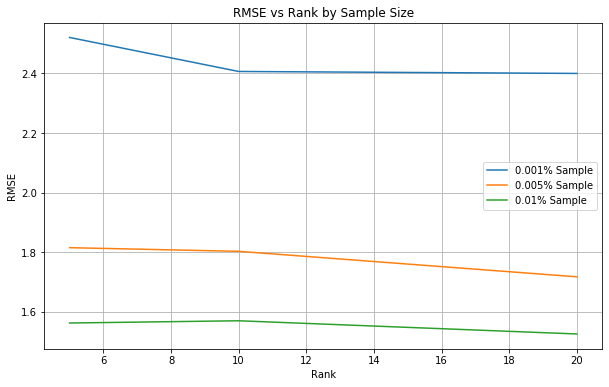

In [54]:
plot_rmse_vs_param(cvModels, rank_list, 'Rank')

In [55]:
for cv in cvModels:
    print(cv.avgMetrics)
best_rank=20

[2.5208710351886188, 2.406703436515813, 2.4000997089692673]
[1.8150041302424498, 1.8027648590484402, 1.7171846553955805]
[1.5620705118289568, 1.5696040226692172, 1.5252708665364574]


#### Tunning Regularization Parameter

In [58]:
reg_list = [0.001, 0.05, 0.1, 0.2]

# Use the best rank found above
als= ALS(maxIter=5, rank=best_rank, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)

paramGrid_2 = ParamGridBuilder().addGrid(als.regParam, reg_list).build()

crossval_2 = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid_2,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)


training_times2, cvModels2, results2 = tune_parameter(crossval_2, paramGrid_2, percentages, all_training_sets)

0:01:36.267541
0:02:05.043913
0:02:47.549340


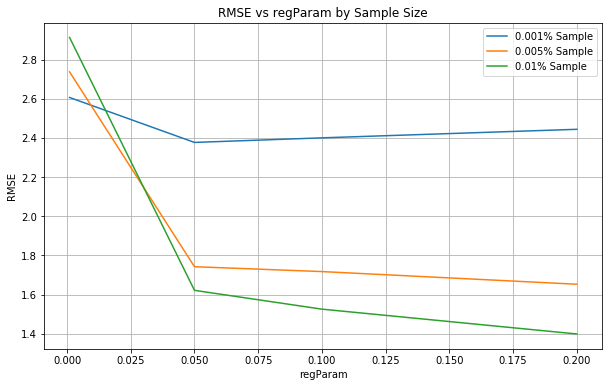

In [59]:
plot_rmse_vs_param(cvModels2, reg_list, 'regParam')

In [60]:
for cv in cvModels2:
    print(cv.avgMetrics)
best_reg = 0.2

[2.6062633832232525, 2.376728250989886, 2.4000997089692673, 2.4437349470727225]
[2.7371086361759316, 1.741988486087179, 1.7171846553955805, 1.6524823516106966]
[2.91276271711076, 1.6213390509996386, 1.5252708665364574, 1.398496263249813]


#### Tunning Number of Iterations

In [61]:
iter_list = list(range(5,25,5))

# Use the best rank and best regParam found above
als= ALS(rank=best_rank, regParam=best_reg, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)
                 
paramGrid_3 = ParamGridBuilder().addGrid(als.maxIter, iter_list).build()

crossval_3 = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid_2,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)


training_times3, cvModels3, results3 = tune_parameter(crossval_3, paramGrid_3, percentages, all_training_sets)

0:01:27.539845
0:02:29.413635
0:03:16.695436


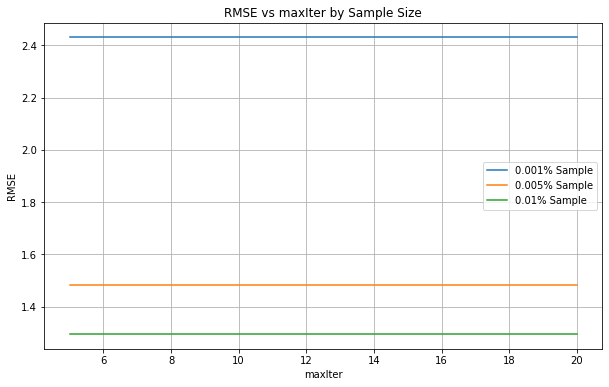

In [62]:
plot_rmse_vs_param(cvModels3, iter_list, 'maxIter')

In [64]:
for cv in cvModels3:
    print(cv.avgMetrics)
best_iter = 10 # default

[2.4305742906384324, 2.4305742906384324, 2.4305742906384324, 2.4305742906384324]
[1.4810357844270297, 1.4810357844270297, 1.4810357844270297, 1.4810357844270297]
[1.295138360350374, 1.295138360350374, 1.295138360350374, 1.295138360350374]


### 3.3.2 Accuracy of ALS Model <a class="anchor" id="3-3-2"></a>

### RSME 

training: with best rank, best reg, best iter

In [65]:
best_als_rmses_train = []
for cv in cvModels3:
    best_als_rmses_train.append(min(cv.avgMetrics))

best_als_rmses_train

[2.4305742906384324, 1.4810357844270297, 1.295138360350374]

test: using the tunned params

In [66]:
best_als_models = []
best_predictions_test = []
best_predictions_train = []
best_als_rmses = []

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

for i in range(len(percentages)):
    best_als= ALS(rank=best_rank, regParam=best_reg, maxIter=best_iter, userCol="userId", 
                  itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative= True)

    best_als_model = als.fit(all_training_sets[i])
    als_predictions_test = best_als_model.transform(all_test_sets[i])
    als_predictions_train = best_als_model.transform(all_training_sets[i])
    rmse = evaluator.evaluate(als_predictions_test)
        
    best_als_models.append(best_als_model)
    best_predictions_test.append(als_predictions_test)
    best_predictions_train.append(als_predictions_train)
    best_als_rmses.append(rmse)

In [67]:
best_als_rmses

[2.240793381700844, 1.3432920600923228, 1.2190040017124122]

### NDCG

In [68]:
best_predictions_test

[DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float]]

In [69]:
best_predictions_train

[DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float],
 DataFrame[userId: int, movieId: int, rating: float, prediction: float]]

In [70]:
# convert pyspark df to pandas df

als_predicted_test_dfs = []  # pandas DF
als_predicted_train_dfs = []  # pandas DF
als_test_ndcgs = []
als_train_ndcgs = []

for (best_prediction_test, best_prediction_train) in zip(best_predictions_test, best_predictions_train):
    # convert test predictions to pandas df
    als_predicted_test_df = best_prediction_test.toPandas()
    als_predicted_test_dfs.append(als_predicted_test_df)
    
    # convert train predictions to pandas df
    als_predicted_train_df = best_prediction_train.toPandas()
    als_predicted_train_dfs.append(als_predicted_train_df)
    
    # ndcg calculation for test predictions
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(als_predicted_test_df, rating_col_name='prediction')  
    als_ndcg = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    als_test_ndcgs.append(als_ndcg)
    
    # ndcg calculation for train predictions
    y_predicted_grouped, ground_truths = get_ratings_for_each_user(als_predicted_train_df, rating_col_name='prediction')  
    als_ndcg_train = ndcg_score(ground_truth=ground_truths, predictions=y_predicted_grouped, k=2)
    als_train_ndcgs.append(als_ndcg_train)


In [71]:
als_test_ndcgs, als_train_ndcgs

([0.9759064907312931, 0.6552750888332256, 0.5662354659500155],
 [0.40992435675618794, 0.38528185643811724, 0.3631051783495496])

### 3.3.3 Coverage of ALS Model <a class="anchor" id="3-3-3"></a>

In [106]:
def get_item_coverage(best_predictions_test, k=5):
    als_item_coverages_test = []
    for i in range(len(best_predictions_test)):
        prediction = best_predictions_test[i]
        percentage = percentages[i]
        predictions_grouped_by_movieIds = prediction.filter(prediction['rating'] >= 3.0).groupby(['movieId'])
        pred_df = predictions_grouped_by_movieIds.agg(sql_func.count(col('userId')))
        pred_df2 = pred_df.filter(pred_df['count(userId)'] >= k)
        n_movie = pred_df2.count()

        potential_recommended_movies = all_test_sets[i].select("movieId").distinct()
        N_movie = potential_recommended_movies.count()

        coverage = (n_movie/N_movie) * 100
        als_item_coverages_test.append(coverage)
        print('Item Coverage ({0:.2}% sample): {1:.2}%'.format(percentage, coverage))
    
    return als_item_coverages_test

In [105]:
als_item_coverages_test = get_item_coverage(best_predictions_test)

Item Coverage (0.001% sample): 0.0%
Item Coverage (0.005% sample): 9.6%
Item Coverage (0.01% sample): 2.1e+01%


In [131]:
als_item_coverages_train = get_item_coverage(best_predictions_train)

Item Coverage (0.001% sample): 3.5e+01%
Item Coverage (0.005% sample): 5.5e+01%
Item Coverage (0.01% sample): 5.9e+01%


In [108]:
def get_user_coverage(best_predictions_test, k=3):
    als_user_coverages_test = []
    for i in range(len(best_predictions_test)):
        prediction = best_predictions_test[i]
        percentage = percentages[i]
        predictions_grouped_by_userIds = prediction.filter(prediction['rating'] >= 3.0).groupby(['userId'])
        pred_df = predictions_grouped_by_userIds.agg(sql_func.count(col('movieId')))
        pred_df2 = pred_df.filter(pred_df['count(movieId)'] >= k)
        n_user = pred_df2.count()

        potential_recommended_users = all_test_sets[i].select("userId").distinct()
        N_user = potential_recommended_users.count()

        coverage = (n_user/N_user) * 100
        als_user_coverages_test.append(coverage)
        print('User Coverage: ({0:.4}% sample): {1:.2}%'.format(percentage, coverage))
    
    return als_user_coverages_test

In [109]:
als_user_coverages_test = get_user_coverage(best_predictions_test)

User Coverage: (0.001% sample): 0.034%
User Coverage: (0.005% sample): 1.8%
User Coverage: (0.01% sample): 5.1%


In [132]:
als_user_coverages_train = get_user_coverage(best_predictions_train)

User Coverage: (0.001% sample): 5.7%
User Coverage: (0.005% sample): 3.2e+01%
User Coverage: (0.01% sample): 5e+01%


# 4. Evaluation <a class="anchor" id="4"></a>

## 4.1 Accuracy <a class="anchor" id="4-1"></a>

### 4.1.1 RMSE <a class="anchor" id="4-1-1"></a>

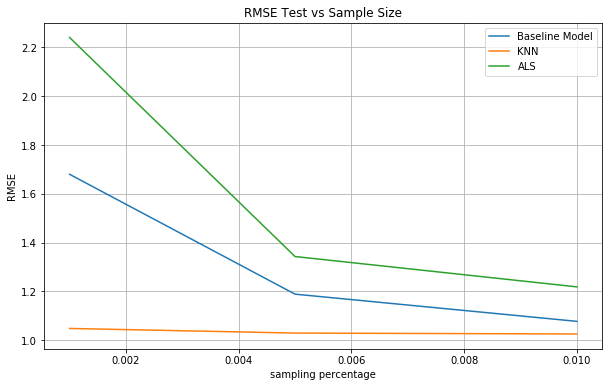

In [83]:
baseline_rmses, baseline_rmses_train
best_als_rmses, best_als_rmses_train

plt.figure(figsize=(10, 6))
plt.plot(percentages, baseline_rmses)
plt.plot(percentages, [min(rmse)  for rmse in knn_rmse_test])
plt.plot(percentages, best_als_rmses)

plt.xlabel('sampling percentage')
plt.ylabel('RMSE')
plt.title('RMSE Test vs Sample Size')
plt.legend(['Baseline Model', 'KNN', 'ALS'])
plt.grid(True)
plt.show()

### 4.1.2 NDCG <a class="anchor" id="4-1-2"></a>

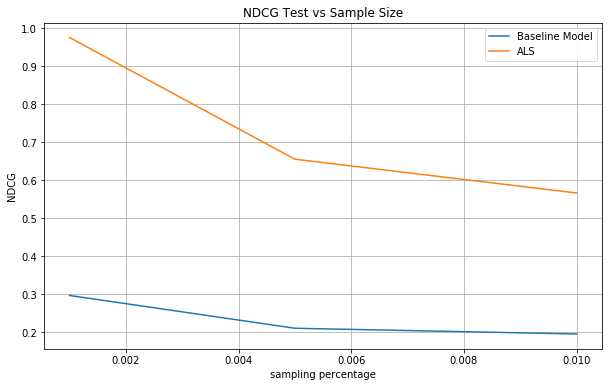

In [84]:
baseline_ndcgs, baseline_ndcgs_train
als_test_ndcgs, als_train_ndcgs

plt.figure(figsize=(10, 6))
plt.plot(percentages, baseline_ndcgs)
# add neighborhood based model
plt.plot(percentages, als_test_ndcgs)

plt.xlabel('sampling percentage')
plt.ylabel('NDCG')
plt.title('NDCG Test vs Sample Size')
plt.legend(['Baseline Model', 'ALS'])
plt.grid(True)
plt.show()

## 4.2 Coverage <a class="anchor" id="4-2"></a>

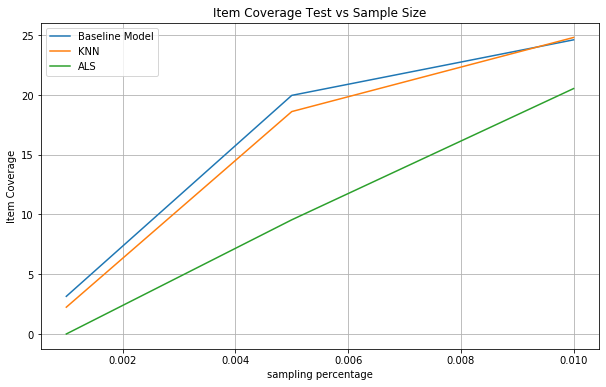

In [219]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, baseline_test_item_coverages)
plt.plot(percentages, knn_item_coverages_test)
plt.plot(percentages, als_item_coverages_test)

plt.xlabel('sampling percentage')
plt.ylabel('Item Coverage')
plt.title('Item Coverage Test vs Sample Size')
plt.legend(['Baseline Model', 'KNN', 'ALS'])
plt.grid(True)
plt.show()

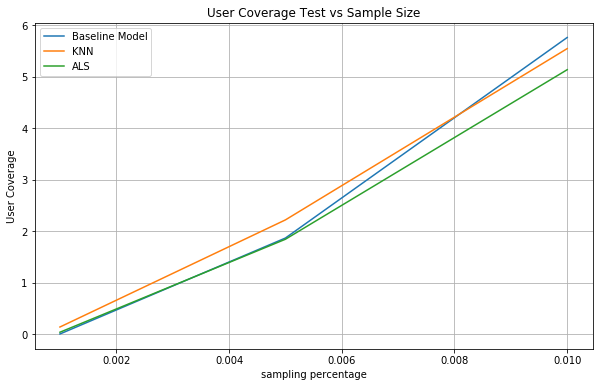

In [220]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, baseline_test_user_coverages)
plt.plot(percentages, knn_user_coverages_test)
plt.plot(percentages, als_user_coverages_test)

plt.xlabel('sampling percentage')
plt.ylabel('User Coverage')
plt.title('User Coverage Test vs Sample Size')
plt.legend(['Baseline Model', 'KNN', 'ALS'])
plt.grid(True)
plt.show()

## 4.3 Changing Sample Size <a class="anchor" id="4-3"></a>

# 5. Conclusion <a class="anchor" id="5"></a>

In [ ]:
# # Generate top 10 movie recommendations for each user
# userRecs = model.recommendForAllUsers(10)
# # Generate top 10 user recommendations for each movie
# movieRecs = model.recommendForAllItems(10)